In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble 
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [3]:
qc = QuantumCircuit(3)
matrix_3qubits = [[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,-1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,0,0,0,-1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]]
oracle_z = UnitaryGate(matrix_3qubits, "U$_\omega$")
#qc.x(0)
#qc.cz(0, 2)
#qc.cz(0,1)
#qc.x(0)
qc.unitary(oracle_z,(0, 1, 2))
oracle_ex3 = qc.to_gate()
#oracle_ex3.name = "U$_\omega$"

In [4]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [5]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [6]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0           ├┤0       ├─░─┤M├──────
        ├───┤│            ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 circuit-2 ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│            ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2           ├┤2       ├─░──╫──╫─┤M├
        └───┘└────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/═════════════════════════════════╩══╩══╩═
                                         0  1  2

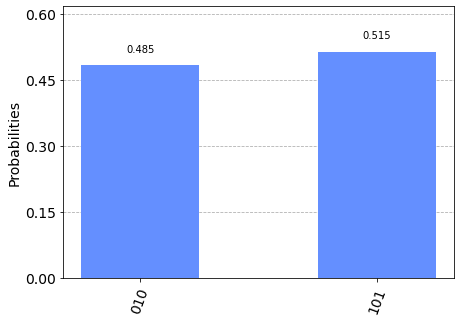

In [7]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)